# Focusing on fixing the data cube (mask the point source)

In this notebook, I look at using two methods of trying to "fix" the data cube by attempting the hide the galaxy point source in the top left corner. It has been posing a problem as Gaussians are being wasted on it. When trying to produce a model for the actual SPIDER, some Gaussians are wasted trying to fit that galaxy.

________________________________________________________________________________________________________________________

## Import all python libraries

Here, I am importing all python libraries I will be using

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ROHSApy import ROHSA
from scipy.optimize import curve_fit
import random

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve

from skimage import data
from skimage.restoration import inpaint

## Download the cube data

The first thing I need to do is download the data cube. I went to the address: https://www.cita.utoronto.ca/GHIGLS/ to download the data cube. The designated region I am working with is the SPIDER region. 

In [2]:
!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits

--2020-07-31 22:10:00--  https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits
Resolving www.cita.utoronto.ca... 128.100.76.44
Connecting to www.cita.utoronto.ca|128.100.76.44|:443... connected.
ERROR: cannot verify www.cita.utoronto.ca’s certificate, issued by “/C=GB/ST=Greater Manchester/L=Salford/O=Sectigo Limited/CN=Sectigo RSA Organization Validation Secure Server CA”:
  Issued certificate has expired.
To connect to www.cita.utoronto.ca insecurely, use ‘--no-check-certificate’.


I am also installing ROHSApy.

In [3]:
!pip install ROHSApy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/python/3.7.3/bin/python3.7 -m pip install --upgrade pip' command.


## Load the data cube

In [4]:
# Now I need to load the data cube that I collected in the above step.
fitsname = "GHIGLS_SPIDER_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[0][:,:,:]
# In the PPV cube, there are 3 axes (Representing the three spaces in the list).
# The first is the velocity axis. The others represent the position coordinates, x and y.

In order to get the axis to be in units of velocity, need this function which converts pixel units to velocity (km/s)

In [6]:
def spec_2_velocity(CRVAL, CDELT, CRPIX, index):
    '''
    Description: 
        This function takes in the parameters from the header and adjusts the \
        velocity range so that is centers at zero (based on the reference). 
    
    Parameters:
        CRVAL - The value of the reference velocity - float
        CDELT - The value of the channel spacing - float
        CRPIX - The value of the pixel where CRVAL occurs - float
    
    Returns:
        This function returns the adjusted velocity list - list
    '''
    vel = [(CRVAL + CDELT * (index[i] - CRPIX)) for i in range(len(index))]
    # Puts in units of km/s
    
    return vel

In [7]:
index_arr = np.arange(cube.shape[0])

cdelt3 = hdr["CDELT3"]/1000. #This allows it to be in units of km/s rather than m/s
crpix3 = hdr["CRPIX3"]
crval3 = hdr["CRVAL3"]/1000. #This allows it to be in units of km/s rather than m/s

vel = np.array(spec_2_velocity(crval3,cdelt3,crpix3,index_arr))

## Function for producing Gaussians

Here, I define a function for a gaussian function. I will be plotting some gaussians manually, so I need this function for later

In [8]:
# Some constants for the integrals:
dv = abs(cdelt3)
C = 1.82243e18

In [9]:
# Function for a single Gaussian 
def one_gauss_func(x, amp, cent, sigma):
    '''
    Description: 
        Evaluates a Gaussian function given some parameters
    
    Parameters:
        x - Value at which the Gaussian is evaluated at - float
        amp - The amplitude of the Gaussian - float
        cent - The location of the of the peak - float 
        sigma - The width of the peak - float
    
    Returns:
        The function evaluated at x - float
    '''
    return amp*np.exp(-(x-cent)**2/(2*sigma**2))

## METHOD 1: Scipy and Astropy Convolutions to Interpolate the Data

Looking at different types of interpolation using scipy and astropy. This code shows the process of interpolating the data with both scipy and astropy.

In [10]:
channel = 385 #np.random.randint(0,710)
print("Channel number = ", channel)
cube1 = np.copy(cube)

Channel number =  385


In [11]:
img = cube1[channel]
img[92:100,0:8] = np.nan
img[143:151,16:24] = np.nan
img_zerod = img.copy()
img_zerod[np.isnan(img)] = 0

In [12]:
kernel = Gaussian2DKernel(x_stddev=1)
scipy_conv = scipy_convolve(img, kernel, mode='same', method='direct')
scipy_conv_zerod = scipy_convolve(img_zerod, kernel, mode='same', method='direct')
astropy_conv = convolve(img, kernel)

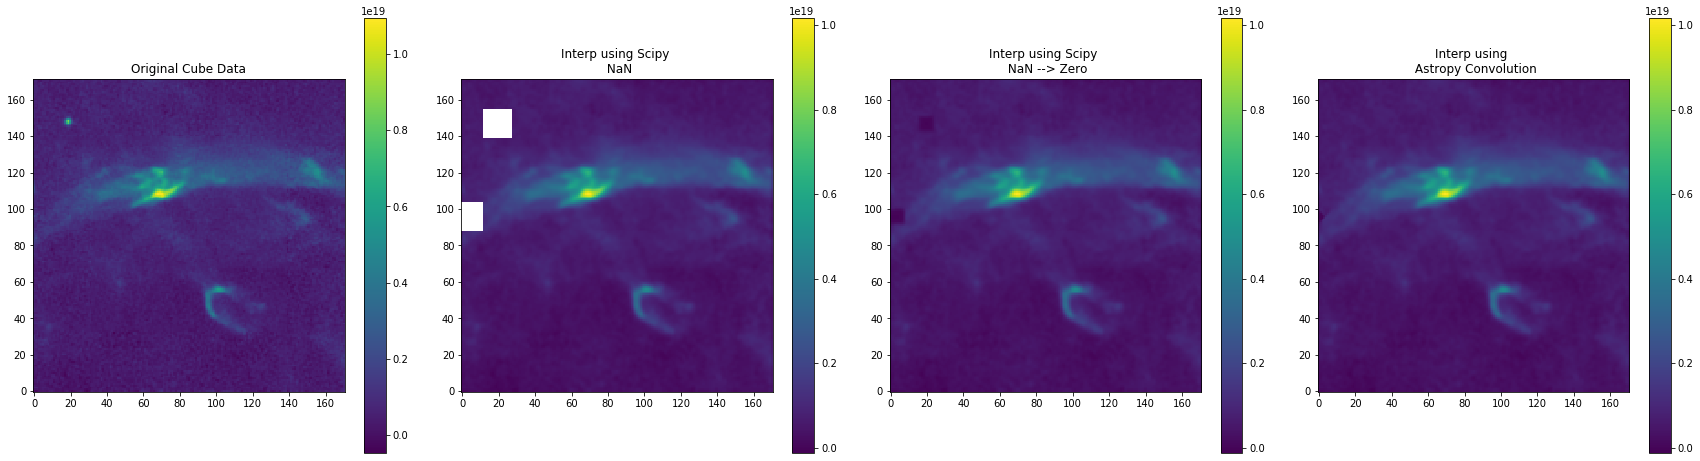

In [13]:
fig = plt.figure(figsize=(30,8))
plt.subplot(1,4,1) ; plt.title("Original Cube Data")
plt.imshow(cube[channel]*C*dv, origin='lower', interpolation='nearest', cmap='viridis'); plt.colorbar()
plt.subplot(1,4,2) ; plt.title("Interp using Scipy \n NaN")
plt.imshow(scipy_conv*C*dv, origin='lower', interpolation='nearest', cmap='viridis'); plt.colorbar()
plt.subplot(1,4,3) ; plt.title("Interp using Scipy \n NaN --> Zero")
plt.imshow(scipy_conv_zerod*C*dv, origin='lower', interpolation='nearest', cmap='viridis'); plt.colorbar()
plt.subplot(1,4,4) ; plt.title("Interp using \n Astropy Convolution")
plt.imshow(astropy_conv*C*dv, origin='lower', interpolation='nearest', cmap='viridis'); plt.colorbar()
plt.subplots_adjust(wspace=0.1)

fig.savefig("Interpolations_using_scipy_and_astropy.pdf", bbox_inches='tight')

From the maps, we see how the different convolution methods tried to interpolate the data. Note, the colour bars indicating the column density have changed. 

In the first map, we see a random channel (velocity) map. From this, we can see the areas that need to be adjusted.

In the second map, The regions to be interpolated are set to "NaN" through scipy and appear white. This is not a good interpolation.

The third map shows the scipy convolution, but the areas of interest are changed from NaN to zero. This does look better, but we should see a smooth transition from these regions.

The fourth map is the astropy convolution. This one appears to be the best interpolation. The map is very smooth and the small point source is gone.

### Looking at the astropy convolution

Since the Astropy convolution was the best, I can look at this one further. I am creating a new data cube with the astropy interpolation.

In [14]:
new_cube_astropy = np.copy(cube)

for i in range(cube.shape[0]):

    img = new_cube_astropy[i]

    img[92:100,0:8] = np.nan
    img[143:151,16:24] = np.nan
    img_zerod = img.copy()
    img_zerod[np.isnan(img)] = 0

    kernel = Gaussian2DKernel(x_stddev=1)

    astropy_conv = convolve(img, kernel)

    new_cube_astropy[i] = astropy_conv

Before moving on, I need to make sure the data (in places other than the regions of interest) is unchanged. Although we do want to interpolate the point source and masked regions, it is important to keep the data true to the original and not alter the original cube.

channel number =  385


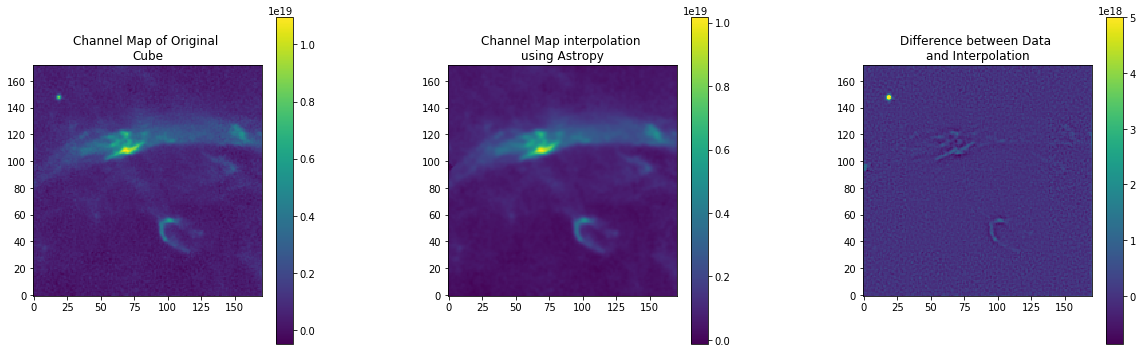

In [15]:
print("channel number = ", channel)
fig = plt.figure(figsize=(20,6))
plt.subplot(1,3,1) ; plt.title("Channel Map of Original \nCube")
plt.imshow(cube[channel]*C*dv, origin='lower') ; plt.colorbar()
plt.subplot(1,3,2) ; plt.title("Channel Map interpolation \nusing Astropy")
plt.imshow(new_cube_astropy[channel]*C*dv, origin='lower') ; plt.colorbar()
plt.subplot(1,3,3) ; plt.title("Difference between Data \nand Interpolation")
plt.imshow(cube[channel]*C*dv - new_cube_astropy[channel]*C*dv, origin="lower", vmax=5.e18)
plt.colorbar()
plt.subplots_adjust(wspace=0.45)
fig.savefig("Cube_data_vs_Astropy_interp.pdf", bbox_inches="tight")

See how well this is fit by taking the original cube data and subtracting it from the new interpolation. We should only see the small galaxy region and the little masked area in the left-middle region along the y-axis. The rest of the map should be zero to ensure that no other data was changed. On the third map, showing the difference between the first and second map, we see the galaxy region is there, which is good, however, the rest of the map is not flat. There are little spots present. This indicates that the cube data in other areas of the spider were also changed.

## METHOD 2: Fixing the cube using Inpainting

This new method of inpainting involves applying a mask on the cube, highlighting only the areas of interest. This is an alternate method that will ensure the data everywhere else is unchanged. We just need to make sure the "interpolation" is smooth.

In [16]:
image_orig = cube.T
# Need to transpose in order to get the the vel axis as the final index
#(as in the example), but this does not change the data.

# Create mask with the defect regions that need to be "fixed"
mask = np.zeros(image_orig.shape[:-1])

mask[16:25, 143:153] = 1 # Galaxy Region in top left corner
mask[12:17, 132:137] = 1 # area below galaxy affecting emission with vel of 40 km/s
mask[0:10, 90:100] = 1 # prevously masked region in the middle, very left
mask[0:2, 101:116] = 1 # Narrow area just above the masked region
mask[5:11, 60:65] = 1 # area affecting emission with vel of 150 km/s

# Defect image over the same region in each velocity channel
image_defect = image_orig.copy()
for channel in range(image_defect.shape[-1]):
    image_defect[np.where(mask)] = 0

image_result = inpaint.inpaint_biharmonic(image_defect, mask, multichannel=True)

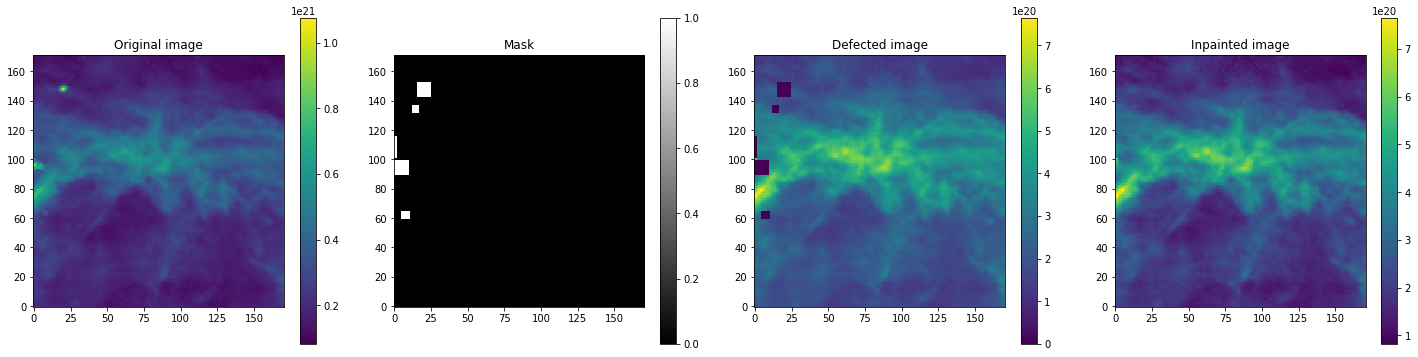

In [17]:
fig = plt.figure(figsize=(25,6))
plt.subplot(1,4,1)
plt.title('Original image')
plt.imshow(np.sum(image_orig.T ,0)*C*dv, origin='lower') ; plt.colorbar()
plt.subplot(1,4,2)
plt.title('Mask')
plt.imshow(mask.T , cmap=plt.cm.gray, origin="lower") ; plt.colorbar() 
plt.subplot(1,4,3)
plt.title('Defected image')
plt.imshow(np.sum(image_defect.T , 0)*C*dv, origin='lower') ; plt.colorbar()
plt.subplot(1,4,4)
plt.title('Inpainted image')
plt.imshow(np.sum(image_result.T , 0)*C*dv,origin='lower') ; plt.colorbar() 
plt.subplots_adjust(wspace=0.15)
fig.savefig("Process_of_inpainting.pdf", bbox_inches="tight")

In [18]:
new_cube_inpaint = image_result.T

Now, we can verify that the inpainting has fixed any problems with the masked region and galaxy, but not tampered any of the data elsewhere in the cube.

Channel =  385


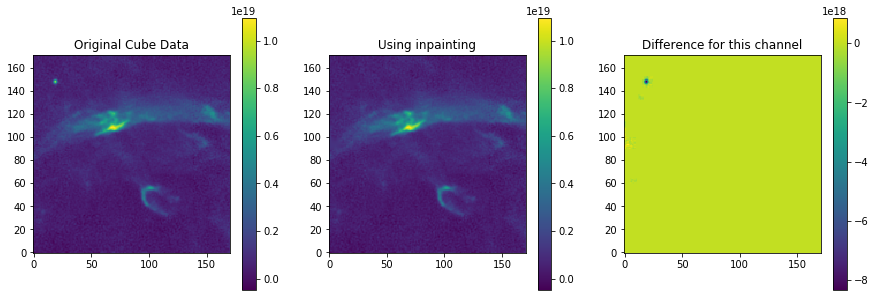

In [19]:
fig = plt.figure(figsize=(15,5))
chan = 385
print("Channel = ", chan)
plt.subplot(1,3,1) ; plt.title("Original Cube Data")
plt.imshow(cube[chan]*C*dv, origin='lower'); plt.colorbar()
plt.subplot(1,3,2) ; plt.title("Using inpainting")
plt.imshow(new_cube_inpaint[chan]*C*dv, origin="lower") ; plt.colorbar()
plt.subplot(1,3,3) ; plt.title("Difference for this channel")
plt.imshow(new_cube_inpaint[chan]*C*dv - cube[chan]*C*dv, origin="lower") ; plt.colorbar()
#plt.imshow(np.sum(new_cube_inpaint, 0) - np.sum(cube, 0), origin="lower") ; plt.colorbar()
plt.subplots_adjust(wspace=0.2)
fig.savefig("Cube_data_vs_Inpainting.pdf", bbox_inches="tight")

## Write out to a .fits file

Now that we have concluded the inpainted cube is the best interpolation, I can write out the new cube to a fits file and start using this new cube for the analysis of the SPIDER.

In [20]:
#new_hdr = fits.Header()
new_hdr = hdr

In [21]:
empty_primary = fits.PrimaryHDU(new_cube_inpaint, header=new_hdr)

hdulist = fits.HDUList([empty_primary])
hdulist.writeto("new_cube_inpaint.fits", clobber=True)